In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adm-lt-2024-2025-hackathon-rag/corpus.csv
/kaggle/input/adm-lt-2024-2025-hackathon-rag/example_submission.csv
/kaggle/input/adm-lt-2024-2025-hackathon-rag/train.csv
/kaggle/input/adm-lt-2024-2025-hackathon-rag/test.csv


In [2]:
pd.set_option(
    "display.max_colwidth", None
)  # This will be helpful when visualizing retriever outputs

In [1]:
# Import libraries
import pandas as pd
import numpy as np

# Load datasets
corpus_df = pd.read_csv("/kaggle/input/adm-lt-2024-2025-hackathon-rag/corpus.csv")
train_df = pd.read_csv("/kaggle/input/adm-lt-2024-2025-hackathon-rag/train.csv")
test_df = pd.read_csv("/kaggle/input/adm-lt-2024-2025-hackathon-rag/test.csv")
example_submission_df = pd.read_csv("/kaggle/input/adm-lt-2024-2025-hackathon-rag/example_submission.csv")

# Preview datasets
print("Corpus:", corpus_df.shape)
print(corpus_df.head(2), "\n")

print("Train:", train_df.shape)
print(train_df.head(2), "\n")

print("Test:", test_df.shape)
print(test_df.head(2), "\n")

print("Submission Format:")
print(example_submission_df.head())

Corpus: (40181, 2)
                                             passage     id
0  New data on viruses isolated from patients wit...   9797
1  We describe an improved method for detecting d...  11906 

Train: (3775, 4)
                                            question  \
0  Name the algorithms for counting multi-mapping...   
1  Which R/bioconductor package is used for integ...   

                                              answer    id  \
0  RNA-Seq is currently used routinely, and it pr...  3009   
1  Sushi.R is a flexible, quantitative and integr...   331   

  relevant_passage_ids  
0  [29444201 28915787]  
1           [24903420]   

Test: (1180, 2)
     id                                  question
0  1702  PBT2 has been tested for which disorder?
1  3135          What does Prevnar 13 consist of? 

Submission Format:
     id             answer
0  1702  this is an answer
1  3135  this is an answer
2   650  this is an answer
3   741  this is an answer
4  2949  this is an answer


Before starting, I want to specify I did not had the chance to follow this course (since the timetable was overlapping with some obbligatory course), so they suggested me to follow it in the second year (as almost every1 where doing actually). This just to say that we are gonna overview some theory topic and concept here as "new", since the professor was so kind to give us two paper to read that collapsed all the info we needed in a short amount of page, to get us ready for this 2 days Hackaton.

With the introduction done, we can now continue with our study:

# Biomedical Retrieval-Augmented Generation (RAG) for Question Answering in Biomedicine

Biomedical retrieval-augmented generation (RAG) is a framework where a question-answering system uses an external knowledge corpus to ground an answer generated by a language model. In RAG, a query is answered by first retrieving relevant context (documents or passages) from a knowledge base and then generating a response conditioned on that retrieved evidence, rather than relying solely on the model’s internal knowledge [paper refence by prefessor](https://arxiv.org/pdf/2312.10997#:~:text=The%20core%20task%20of%20RAG,to%20QA%2C%20RAG%20is%20continuously)

This approach is particularly useful in the biomedical domain, where up-to-date, and domain-specific information is critical. The core RAG pipeline involves a retriever module to fetch candidate passages, optional reranker modules to refine those passages, and a generator module (LLM) to produce the final answer using the question and retrieved text.

# RAG Architecture in Biomedical QA

A basic RAG architecture comprises two main components – the Retrieval module and the Generation module – each of which can have internal sub-components tailored for biomedical text:

- **Retriever & Encoder:** The retriever acts as an internal search engine to identify relevant text snippets from a large biomedical corpus. Documents in the corpus are first indexed by splitting them into manageable segments (or “chunks”) and encoding each chunk into a vector representation using a biomedical encoder model.

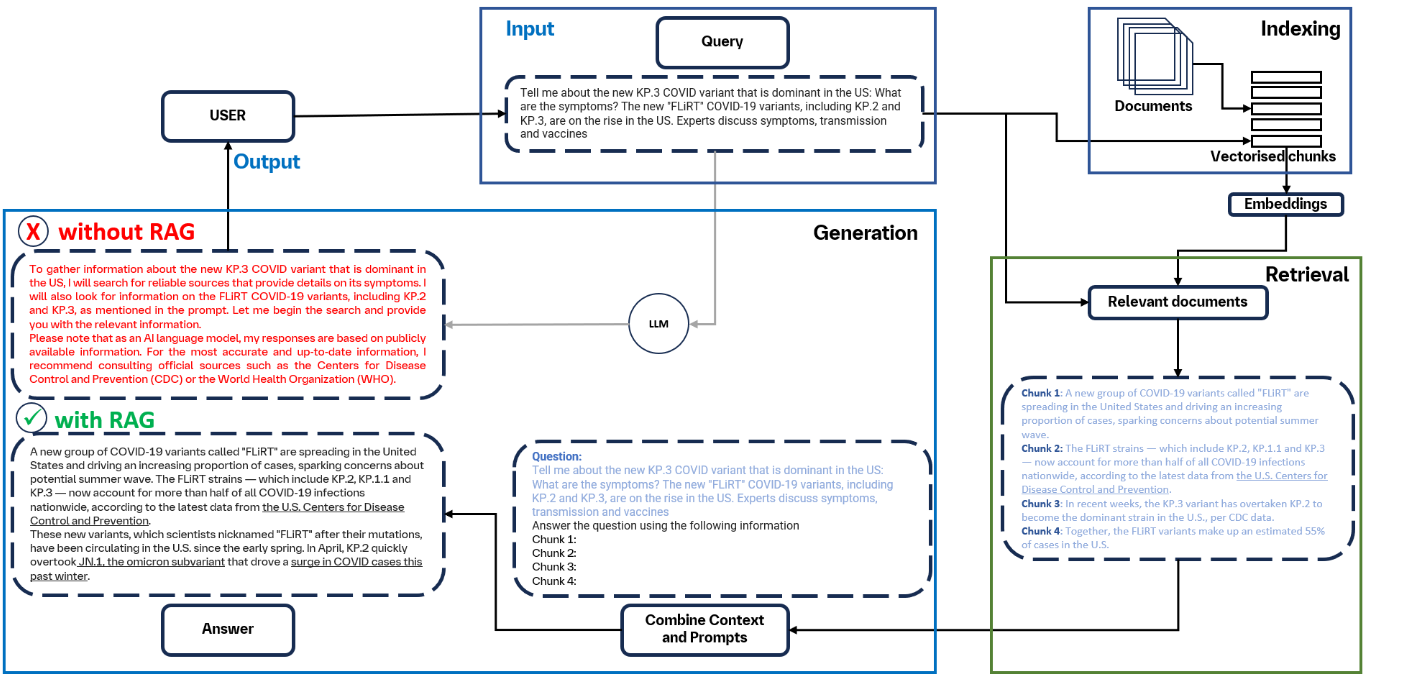

[Source at page 10](https://www.researchgate.net/publication/382227452_Retrieval_Augmented_Generation_for_Large_Language_Models_in_Healthcare_A_Systematic_Review)

For example, an encoder might be a Transformer model that maps each passage to an embedding in a high-dimensional space. All chunk embeddings are stored in a vector index. At query time, the user’s question is encoded into the same vector space, and the retriever finds the top-$k$ most similar chunks by nearest-neighbor search. In other words, the system retrieves the passages whose embeddings have high cosine similarity (or low distance) to the query embedding
researchgate.net
researchgate.net
. This dense retrieval approach captures semantic relevance, which is crucial in biomedicine where queries often use technical terms or synonyms. In some systems, a sparse retrieval component like BM25 (lexical search) may be used alongside or instead of dense retrieval to ensure exact keyword matches (for instance, matching a specific gene or protein name). The retriever may thus be a hybrid of dense and sparse search, or even include structured knowledge base lookups, to maximize recall of relevant information. Optionally, the retriever stage can also incorporate metadata filtering (e.g., restrict by publication date or source) if the corpus has metadata that can narrow results.

This dense retrieval approach captures semantic relevance, which is crucial in biomedicine where queries often use technical terms or synonyms. In some systems, a sparse retrieval component like BM25 (lexical search) may be used alongside or instead of dense retrieval to ensure exact keyword matches (for instance, matching a specific gene or protein name). The retriever may thus be a hybrid of dense and sparse search, or even include structured knowledge base lookups, to maximize recall of relevant information. Optionally, the retriever stage can also incorporate metadata filtering (restrict by publication date or source) if the corpus has metadata that can narrow results.

- **Reranker:** After initial retrieval, a reranker module can refine the set of candidate passages. Rerankers are typically more expensive models that take the query and each retrieved passage as input and output a relevance score. The passages are then sorted by this score, and the top few are selected for answer generation. Reranking can significantly improve the quality of context fed to the generator by ensuring the most relevant and specific snippets are used.
[Same paper page 17](https://www.researchgate.net/publication/382227452_Retrieval_Augmented_Generation_for_Large_Language_Models_in_Healthcare_A_Systematic_Review)

In biomedical QA, rerankers can be fine-tuned on domain data so that they prioritize passages containing the answer or strong supporting evidence. In newer approaches, large LLMs themselves are used as rerankers: for example, by prompting an LLM to evaluate the relevance of each retrieved document before answering, effectively filtering out distracting or off-topic passages.
[Source](https://arxiv.org/pdf/2312.10997#:~:text=Extraction%20%28IE%29%20tasks,data%20char%02acteristics%20on%20LLMs%20can)

Reranking (whether via a smaller cross-encoder or an LLM “critique”) helps address one cause of hallucinations – the model being led astray by irrelevant context.

- **Generator (Reader):** The generation module is usually a sequence-to-sequence language model or chat model that we prompt with the question and the retrieved context to produce a final answer. In a RAG setup, the generator serves as an augmented reader: it reads the provided snippets and the question, and then writes an answer grounded in that information. Modern RAG systems often use large language models (LLMs) as generators, which might be as powerful as GPT-4 or domain-specific models like BioGPT, etc. The input to the generator is typically a prompt containing the question and the retrieved passages (often concatenated or listed). The generator’s output is a free-form answer, which could be a concise fact, a list of entities, or a longer explanation, depending on the question type. The key is that the generator should rely on the retrieved evidence rather than unsupported parametric knowledge. Because the generator is an LLM, it has the ability to compose and contextualize information from multiple retrieved documents (for multi-document questions), using its language understanding to produce a coherent answer. Some architectures allow the generator to iteratively request more information (multi-turn retrieval) or use a chain-of-thought approach, but the simplest and most common paradigm is a single retrieval step followed by generation.

[Source page 10, Capitolo: V. AUGMENTATION PROCESS IN RAG ](https://arxiv.org/pdf/2312.10997)

The entire RAG workflow – indexing, retrieval, and answer generation – enables open-domain QA on biomedical text: the system can answer questions using a large external knowledge base without having explicitly seen those answers during training.

**Training and Tuning:** Many RAG systems are built by leveraging pre-trained components and then fine-tuning them on the specific QA task or domain. For example, a biomedically pretrained BERT model could be fine-tuned as a dense passage retriever using a set of question–relevant passage pairs (if available), improving its recall on biomedical queries. Likewise, the generator LLM can be fine-tuned (or instruct-tuned) on biomedical Q&A data to better follow instructions and generate factual answers. This targeted fine-tuning on domain-specific data often yields significant gains in accuracy, and is a major advantage of using open-source models that can be further trained.
[Source](https://arxiv.org/pdf/2312.10997#:~:text=Targeted%20fine,it%20can%20enable%20LLM%20to)

Fine-tuning adapts the LLM to use domain terminology correctly and to format answers as desired (for instance, ensuring it gives a short factoid if the task expects it). In practice, many top-performing systems use a combination of pre-training on general data (to endow broad language competence), domain-adaptive pre-training (continuing pre-training on biomedical text corpora), and fine-tuning on task data (QA pairs) to build a robust RAG model.


# Evaluation in Biomedical QA and Optimizing F1 for our Competition
In this competition the evaluation metric is a token-level F1 score, which is commonly used in QA benchmarks like SQuAD and BioASQ to give partial credit for overlapping answer phrases. The F1 score measures the overlap between the predicted answer and the ground truth answer in terms of precision and recall of tokens.
[More info here](https://milvus.io/ai-quick-reference/how-can-we-evaluate-factual-correctness-of-an-answer-when-a-reference-answer-is-available-consider-exact-match-or-f1-as-used-in-qa-benchmarks-like-squad)

In simple terms, it checks what fraction of the answer tokens are correct (precision) and what fraction of the ground truth tokens were captured (recall), and then computes the harmonic mean. This means a prediction can earn some points for being partially correct even if it's not an exact match, as long as it includes many of the correct keywords. 

For instance, if the true answer is "aspirin and beta blockers" and a system predicts "aspirin and beta-blockers in therapy," the overlapping tokens ("aspirin", "beta", "blockers") would yield a high F1 even if there's an extra phrase. By contrast, missing a key token or adding incorrect tokens will lower the F1. 

> What drives a high F1 in biomedical QA?

Ultimately, precision and recall of the answer content. To maximize recall, the system must include all the essential information from the ground truth in its answer. This usually hinges on retrieving the right facts: if the relevant passage containing the answer is not retrieved, the generator might produce an incomplete or wrong answer, hurting recall. On the precision side, the model should avoid adding extraneous or unsupported information, as extra words not in the ground truth will count as false positives. In practice, achieving high F1 means the answer should be succinct and specific, matching the wording of the ground truth as closely as possible. In a competition setting, it is often beneficial for the generator to use phrasing from the source text (to ensure correct terminology and maximize token overlap with reference answers). This is a natural advantage of RAG – the model can directly copy or lightly rephrase the relevant snippet from a retrieved document, which often yields a precise answer that aligns with expected answers.
[Source at page 10](https://www.researchgate.net/publication/382227452_Retrieval_Augmented_Generation_for_Large_Language_Models_in_Healthcare_A_Systematic_Review#:~:text=diseases%20and%20conditions,time%20using%20the)


# Building a Top-Performing Biomedical RAG Model

- **Use the Best Generator Model Available:** Many recent studies use GPT-3.5 or GPT-4 as the LLM in healthcare RAG systems
[Source](https://www.researchgate.net/publication/382227452_Retrieval_Augmented_Generation_for_Large_Language_Models_in_Healthcare_A_Systematic_Review#:~:text=that%20proprietary%20models%20such%20as,It%20is%20important)

In the biomedical space specifically, considering models that have been domain-tuned: for example, BioGPT (from Microsoft) is a GPT-2 style model trained on biomedical text; more recent ones include BioMedLM or PMC-LLaMA, trained on PubMed articles. While these specialized models may not match GPT-4’s general ability, they often excel in terminology and factual recall of biomedical knowledge.

- **Strong Retrievers (Embedding Models):** The retriever’s quality is paramount because wrong or missed retrievals cannot yield correct answers. For dense retrieval, a popular choice is to use a bi-encoder model fine-tuned for question-passage similarity. 

- **Memory and Context Length:** Biomedical answers might require fairly large contexts (some questions might need a whole abstract or multiple paragraphs as evidence). So, it’s advantageous if your generator LLM supports long input contexts (16k or more token context). 
[Source under paragraph 1. Retriever - embeddings](https://huggingface.co/learn/cookbook/en/advanced_rag)



In [16]:
#!pip install tiktoken

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [5]:
import tiktoken  
enc = tiktoken.encoding_for_model("gpt-3.5-turbo")

# Function to count tokens
def count_tokens(text):
    return len(enc.encode(str(text)))

# Apply to each set
train_df["question_length"] = train_df["question"].apply(len)
train_df["question_tokens"] = train_df["question"].apply(count_tokens)

test_df["question_length"] = test_df["question"].apply(len)
test_df["question_tokens"] = test_df["question"].apply(count_tokens)

corpus_df["passage_length"] = corpus_df["passage"].apply(len)
corpus_df["passage_tokens"] = corpus_df["passage"].apply(count_tokens)

# Show summaries
print("Train question stats:")
print(train_df["question_length"].describe())
print(train_df["question_tokens"].describe())

print("\nTest question stats:")
print(test_df["question_length"].describe())
print(test_df["question_tokens"].describe())

print("\nCorpus passage stats:")
print(corpus_df["passage_length"].describe())
print(corpus_df["passage_tokens"].describe())


Train question stats:
count    3775.000000
mean       57.305430
std        23.422565
min        13.000000
25%        41.000000
50%        54.000000
75%        70.000000
max       215.000000
Name: question_length, dtype: float64
count    3775.000000
mean       13.253775
std         4.927156
min         3.000000
25%        10.000000
50%        12.000000
75%        16.000000
max        44.000000
Name: question_tokens, dtype: float64

Test question stats:
count    1180.000000
mean       56.734746
std        23.736073
min        13.000000
25%        41.000000
50%        53.000000
75%        70.000000
max       192.000000
Name: question_length, dtype: float64
count    1180.000000
mean       13.191525
std         5.061514
min         3.000000
25%        10.000000
50%        12.000000
75%        15.250000
max        49.000000
Name: question_tokens, dtype: float64

Corpus passage stats:
count    40181.000000
mean      1483.755282
std        673.713186
min          3.000000
25%       1113.000000

### Corpus Size is a Challenge
- 40,181 biomedical passages
- Some of them are very long (up to 8,653 tokens)

is crucial to avoid:

- Cutting mid-sentence (→ hallucinations),

- Including too much irrelevant info (→ noisy generations),

- Missing relevant details (→ low recall).




# Preprocessing, Chunking, and Embedding the Corpus
Working with a large biomedical text corpus (40k passages in this competition) requires thoughtful preprocessing to ensure efficient and relevant retrieval.

- **Cleaning and Normalization:** Raw biomedical text can contain artifacts like references, special characters (Greek letters, chemical formulas), or OCR errors if scanned. Clean the text by removing or marking irrelevant sections (e.g. figure captions, references list) if present, because these can confuse the retriever. Normalize text where appropriate – for instance, unify different ways of writing units ("mg", "milligrams") or gene names (Greek letter vs spelled out) if you expect queries to use one form and documents another. Lowercasing everything is standard for many retrieval models.
  
- **Chunking Strategy:** Chunks should be small enough to be specific (so that each chunk likely focuses on a single concept or fact) but large enough to contain complete contexts needed to answer a question. In practice, chunk sizes of around 100 to 300 words (or roughly 50 to 200 tokens) are common for QA tasks. For example, splitting a research article by paragraphs, The goal is to have each chunk be about one subtopic or statement.

  - If chunks are too short, the answer might be split across multiple chunks and not fully present in any one.

  - If chunks are too long, the embedding has to represent many concepts and you might retrieve a chunk that contains some relevant info and a lot of irrelevant info, which could distract the generator.

One recommended practice is to use overlapping windows, allowing some overlap (like 20%) so that if an answer falls on a boundary, it will likely be contained fully in at least one chunk. 
LangChain provide recursive character text splitters that try to break text at logical boundaries (paragraphs, sentences) while respecting length limits. This was used in a clinical QA study where they recursively chunked patient notes to preserve whole pieces of context
[Source at page 16](https://www.researchgate.net/publication/382227452_Retrieval_Augmented_Generation_for_Large_Language_Models_in_Healthcare_A_Systematic_Review#:~:text=that%20proprietary%20models%20such%20as,It%20is%20important)

- **Embedding the Chunks:** Once chunks are ready, compute their vector embeddings using the encoder model. Batch processing to speed it up. Each embedding will be a high-dimensional vector (e.g. 768-dimensional if using BERT-based). It’s wise to normalize embeddings (many use cosine similarity which implicitly normalizes, but if using dot product, explicitly normalize vectors so that lengths don’t skew scores).

| Technique                  | What it does                                               |
| -------------------------- | --------------------------------------------------------------------------------- |
| **Overlap-aware chunking** | Ensures concepts aren't split mid-sentence (vital for drugs, proteins, diseases). |
| **Metadata retention**     | E.g., MeSH terms, IDs — improves reranking or filtering.                          |
| **Text cleaning**          | Remove headers, long IDs, artifacts (especially in PubMed abstracts).             |
| **Standard chunk size**    | 256–384 tokens ideal for biomedical models.|


In [2]:
import torch
print(torch.cuda.is_available())  
# We use GPU to improve performance (timely speaking)

True


In [3]:
import gc
import torch
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument
from sentence_transformers import SentenceTransformer

# === SETTINGS ===
EMBEDDING_MODEL_NAME = "BAAI/bge-base-en-v1.5"
CHUNK_SIZE = 512
CHUNK_OVERLAP = 50

# === CLEAN GPU MEMORY ===
def clear_cuda():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

clear_cuda()

# === LOAD TOKENIZER & MODEL ===
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
model = SentenceTransformer(EMBEDDING_MODEL_NAME, device="cuda")

# === LANGCHAIN SPLITTER ===
splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer=tokenizer,
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    add_start_index=True,
    strip_whitespace=True,
)

# === CONVERT corpus_df TO LangchainDocuments ===
documents = []
for _, row in tqdm(corpus_df.iterrows(), total=len(corpus_df), desc="Preparing docs"):
    doc = LangchainDocument(
        page_content=row["passage"],
        metadata={"source": row["id"]}  # you can extend this if needed
    )
    documents.append(doc)

# === SPLIT INTO CHUNKS ===
docs_processed = []
for doc in tqdm(documents, desc="Splitting into chunks"):
    docs_processed.extend(splitter.split_documents([doc]))

# === REMOVE DUPLICATES ===
unique_docs = list({doc.page_content: doc for doc in docs_processed}.values())

# === CONVERT BACK TO DataFrame ===
chunked_df = pd.DataFrame([
    {
        "chunk": doc.page_content,
        "source_id": doc.metadata["source"],
        "start_index": doc.metadata.get("start_index", -1)
    }
    for doc in unique_docs
])

print("Chunking complete.")
print("Total unique chunks:", len(chunked_df))
print(chunked_df.head())


2025-05-29 15:01:28.344432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748530888.373482      88 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748530888.380897      88 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Splitting into chunks: 100%|██████████| 40181/40181 [03:05<00:00, 216.81it/s]


Chunking complete.
Total unique chunks: 49953
                                               chunk  source_id  start_index
0  New data on viruses isolated from patients wit...       9797            0
1  We describe an improved method for detecting d...      11906            0
2  We have studied the effects of curare on respo...      16083            0
3  Kinetic and electrophoretic properties of 230-...      23188            0
4  Male Wistar specific-pathogen-free rats aged 2...      23469            0


[Our Model](https://huggingface.co/michiyasunaga/BioLinkBERT-base)

We creare a dense embedding index for the chunked corpus processed in the previous step

| Feature                   | Why it's good                                                                       |
| ------------------------- | ----------------------------------------------------------------------------------- |
| **BioLinkBERT**           | Trained on PubMed + citations. Best performance on QA (e.g. PubMedQA, MedQA-USMLE). |
| **Document link context** | Especially useful in biomedical settings, where citations ≈ knowledge.              |
| **Base model (vs large)** | Lighter, faster, fits better into GPU RAM during batch embedding.                   |


In [18]:
from sentence_transformers import SentenceTransformer
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document
from langchain.vectorstores.utils import DistanceStrategy
from tqdm import tqdm
import numpy as np

# embedding
embedding_model = HuggingFaceEmbeddings(
    model_name="pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb",
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # cosine similarity
)

# Extract only text from documents
texts = [doc.page_content for doc in docs_processed]

# embedding calculation
print(" Calcolo degli embeddings per ogni documento...")

embeddings = []

# tqdm allow us to visualize a progress bar, since this passage take some minutes is better to see how is going also for any debugging or to preparate for other runnings
for text in tqdm(texts, desc="Embedding passages", ncols=100):
    embedding = embedding_model.embed_query(text)
    embeddings.append(embedding)

print("Embeddings completati:", len(embeddings))


# FAISS index
print(" Creazione del FAISS index...")

documents = [Document(page_content=chunk) for chunk in texts]

vectorstore = FAISS.from_documents(
    documents=documents,
    embedding=embedding_model,
    distance_strategy=DistanceStrategy.COSINE  # Per cosine similarity
)


 Calcolo degli embeddings per ogni documento...


Embedding passages: 100%|█████████████████████████████████████| 49953/49953 [11:10<00:00, 74.49it/s]


Embeddings completati: 49953
 Creazione del FAISS index...


TypeError: FAISS.from_embeddings() missing 2 required positional arguments: 'text_embeddings' and 'embedding'

In [24]:
vectorstore = FAISS.from_documents(
    documents=documents,
    embedding=embedding_model,
    distance_strategy=DistanceStrategy.COSINE
)

print("✅ FAISS index creato.")

✅ FAISS index creato.


In [25]:
user_query = "What is the role of biomarkers in cancer detection?"
results = vectorstore.similarity_search(user_query, k=3)
for i, doc in enumerate(results, 1):
    print(f"\n📄 Documento #{i}\n{doc.page_content[:500]}...\n")



📄 Documento #1
OBJECTIVE: Noninvasive biomarkers are used routinely in the clinical management 
of several cancers but bladder cancer detection and surveillance remains 
dependent on invasive procedures such as cystoscopy. No validated biomarker 
currently exists in routine clinical practice other than cytology. Gene-based 
testing has shown great promise for biomarker profiling and this review 
addresses the current state of biomarker research in bladder cancer.
MATERIALS AND METHODS: A comprehensive review o...


📄 Documento #2
A biomarker is a characteristic that is objectively measured and evaluated as an 
indicator of normal biologic processes, pathogenic processes, or pharmacologic 
responses to a therapeutic intervention. In cancer, a biomarker refers to a 
substance or process that is indicative of the presence of cancer in the body. A 
biomarker might be either a molecule secreted by a tumor or it can be a specific 
response of the body to the presence of cancer. Genetic, epi

In [27]:
retrieved_docs = vectorstore.similarity_search(user_query, k=5)
retrieved_context = "\n\n".join([doc.page_content for doc in retrieved_docs])

In [36]:
!pip uninstall -y langchain langchain-core langchain-community
!pip install langchain==0.1.17 langchain-core==0.1.49 langchain-community==0.0.36

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached langchain-0.1.17-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.6/867.6 kB 11.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.1.2
    Uninstalling tenacity-9.1.2:
      Successfully uninstalled tenacity-9.1.2
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.23
    Uninstalling langsmith-0.3.23:
      Successfully uninstalled langsmith-0.3.23
  Attempting uninstall: langchain

In [41]:
!pip install --upgrade langchain langchain-community langchain-openai faiss-cpu pydantic>=2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [93]:
from tqdm import tqdm
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer

# nltk.download("punkt")

tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-base-en-v1.5")

def strict_token_chunking(text, tokenizer, max_tokens=450, overlap_tokens=50):
    """
    Sentence-aware + token-count-capped chunking with controlled overlap.
    Prevents chunk overflow (e.g., >512 tokens).
    """
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = []
    current_len = 0

    for sent in sentences:
        sent_tokens = tokenizer.encode(sent, add_special_tokens=False)
        if current_len + len(sent_tokens) > max_tokens:
            # finalize chunk
            chunks.append(" ".join(current_chunk))

            # Prepare overlap
            overlap_chunk = []
            overlap_len = 0
            for prev_sent in reversed(current_chunk):
                prev_tokens = tokenizer.encode(prev_sent, add_special_tokens=False)
                if overlap_len + len(prev_tokens) > overlap_tokens:
                    break
                overlap_chunk.insert(0, prev_sent)
                overlap_len += len(prev_tokens)

            current_chunk = overlap_chunk + [sent]
            current_len = overlap_len + len(sent_tokens)
        else:
            current_chunk.append(sent)
            current_len += len(sent_tokens)

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks
    
corpus_chunks = []
chunk_ids = []
chunk_numbers = []

for _, row in tqdm(corpus_df.iterrows(), total=len(corpus_df), desc="Chunking passages"):
    passage = str(row["passage"]).strip().replace("\n", " ")
    pid = row["id"]
    chunks = strict_token_chunking(passage, tokenizer)

    for idx, chunk in enumerate(chunks):
        corpus_chunks.append(chunk)
        chunk_ids.append(pid)
        chunk_numbers.append(idx)

chunked_df = pd.DataFrame({
    "chunk": corpus_chunks,
    "source_id": chunk_ids,
    "chunk_number": chunk_numbers
})

chunked_df.drop_duplicates(subset=["chunk"], inplace=True)
chunked_df.reset_index(drop=True, inplace=True)

print("Chunking complete. Total:", len(chunked_df))


Chunking passages: 100%|██████████| 40181/40181 [01:13<00:00, 548.05it/s]


Chunking complete. Total: 46819


BAAI model below was not working cause our GPU memory was full, we check, remove and procede

In [101]:
import gc
import torch

print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 2), "GB")
print("Reserved: ", round(torch.cuda.memory_reserved(0) / 1024**3, 2), "GB")

Allocated: 14.45 GB
Reserved:  14.55 GB


In [102]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [103]:
print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 2), "GB")
print("Reserved: ", round(torch.cuda.memory_reserved(0) / 1024**3, 2), "GB")

Allocated: 3.17 GB
Reserved:  9.23 GB


In [104]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer("BAAI/bge-base-en-v1.5")

# Convert column to list
texts = chunked_df["chunk"].tolist()

# Encode in batches
print("Encoding chunks...")
embeddings = model.encode(
    texts,
    batch_size=64,              # Adjust based on memory
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True   # Cosine similarity is now dot product
)

# Save embeddings to DataFrame
chunked_df["embedding"] = [emb.tolist() for emb in embeddings]


Encoding chunks...


Batches:   0%|          | 0/732 [00:00<?, ?it/s]

KeyboardInterrupt: 

- **Indexing for Fast Retrieval:** Load the embeddings into an efficient vector search index. FAISS (Facebook AI Similarity Search) is a popular choice that can handle millions of vectors on a single machine and offers fast approximate nearest neighbor search

[Page 16 section 3.5](https://www.researchgate.net/publication/382227452_Retrieval_Augmented_Generation_for_Large_Language_Models_in_Healthcare_A_Systematic_Review#:~:text=that%20proprietary%20models%20such%20as,It%20is%20important)

In [94]:
# Build FAISS index
dim = corpus_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dim)
faiss_index.add(corpus_embeddings)
print(f"FAISS index built with {faiss_index.ntotal} vectors.")

FAISS index built with 44048 vectors.


### Validate FAISS Retrieval Quality (Train Set)

1. BioLinkBERT to embed train questions,

2. FAISS to retrieve top-k passages,

3. Compare retrieved passage IDs with relevant_passage_ids in the train set.



Interpretation:

| Metric                       | Meaning                                                                                  |
| ---------------------------- | ---------------------------------------------------------------------------------------- |
| **Top-k Retrieval Hit Rate** | % of training queries for which at least one relevant passage is in the top-k retrieved. |
| > 0.7                        | Very good signal, proceed to generation phase.                                           |
| < 0.5                        | Consider: better chunking, filtering, reranking (e.g., ColBERT, splade, etc.).           |


In [29]:
import ast
from tqdm import tqdm
import numpy as np

# Clean and parse relevant_passage_ids
def parse_passage_ids(x):
    x = x.strip()
    if x.startswith("[") and x.endswith("]"):
        x = x[1:-1]  # Remove brackets
    x = x.replace(" ", ",")  # Replace space with comma
    return [int(pid) for pid in x.split(",") if pid.strip().isdigit()]

# Parse passage ID list
true_passage_ids = train_df['relevant_passage_ids'].apply(parse_passage_ids).tolist()
train_questions = train_df['question'].tolist()

# Embed train questions using BioLinkBERT
train_embeddings = get_biolinkbert_embedding(train_questions, batch_size=16)

# Search top-k retrieved chunks
k = 5
_, retrieved_indices = faiss_index.search(train_embeddings, k)

# Map FAISS indices back to passage IDs in chunked_df
retrieved_passage_ids = chunked_df.iloc[retrieved_indices.flatten()]['source_id'].values.reshape(retrieved_indices.shape)

# Evaluate top-k hit rate
hits = []
for true_ids, retrieved_ids in zip(true_passage_ids, retrieved_passage_ids):
    hit = any(int(pid) in true_ids for pid in retrieved_ids)
    hits.append(hit)

top_k_hit_rate = np.mean(hits)
print(f"Top-{k} Retrieval Hit Rate: {top_k_hit_rate:.4f}")


Embedding chunks: 100%|██████████| 236/236 [00:05<00:00, 42.84it/s]


✅ Top-5 Retrieval Hit Rate: 0.1322


~13% of the questions have at least one correct passage (from relevant_passage_ids) among the top-5 retrieved chunks.

In [49]:
!pip install -q torch transformers accelerate bitsandbytes langchain langchain-community faiss-cpu sentence-transformers


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 25.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.4/438.4 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you 

In [50]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain.schema import Document
from uuid import uuid4
import faiss
import pandas as pd

# Load corpus
corpus_df = pd.read_csv("/kaggle/input/adm-lt-2024-2025-hackathon-rag/corpus.csv")

# Wrap into LangChain Document format
docs = [Document(page_content=row['passage'], metadata={"id": int(row['id'])})
        for _, row in corpus_df.iterrows()]

# Split documents
splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=30)
split_docs = splitter.split_documents(docs)

# Load embedding model
embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5")

# Setup FAISS index
index = faiss.IndexFlatL2(768)  # 768 = dim of BGE embeddings
docstore = InMemoryDocstore()
uuids = [str(uuid4()) for _ in split_docs]

vectorstore = FAISS(embedding_function=embedding_model,
                    index=index,
                    docstore=docstore,
                    index_to_docstore_id=dict(enumerate(uuids)))

vectorstore.add_documents(split_docs, ids=uuids)


/tmp/ipykernel_35/3372221152.py:22: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

KeyboardInterrupt: 

In [51]:
from langchain.schema import Document
from tqdm.notebook import tqdm  # for loading bar

docs = [Document(page_content=row['passage'], metadata={"id": int(row['id'])})
        for _, row in tqdm(corpus_df.iterrows(), total=corpus_df.shape[0], desc="Wrapping into Documents")]

print(f"Total documents wrapped: {len(docs)}")
print("Example doc:", docs[0])


Wrapping into Documents:   0%|          | 0/40181 [00:00<?, ?it/s]

Total documents wrapped: 40181
Example doc: page_content='New data on viruses isolated from patients with subacute thyroiditis de Quervain 
are reported. Characteristic morphological, cytological, some physico-chemical 
and biological features of the isolated viruses are described. A possible role 
of these viruses in human and animal health disorders is discussed. The isolated 
viruses remain unclassified so far.' metadata={'id': 9797}


In [52]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=30)
split_docs = splitter.split_documents(docs)

print(f"Total chunks created: {len(split_docs)}")
print("Example chunk:")
print(split_docs[0].page_content[:300])  # Show part of first chunk
print("Metadata:", split_docs[0].metadata)


Total chunks created: 143166
Example chunk:
New data on viruses isolated from patients with subacute thyroiditis de Quervain 
are reported. Characteristic morphological, cytological, some physico-chemical 
and biological features of the isolated viruses are described. A possible role 
of these viruses in human and animal health disorders is d
Metadata: {'id': 9797}


In [53]:
from langchain_community.embeddings import HuggingFaceEmbeddings
embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5")

Embedding model loaded: BAAI/bge-base-en-v1.5


In [54]:
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
import faiss
from uuid import uuid4
from tqdm.notebook import tqdm

# Init index and docstore
index = faiss.IndexFlatL2(768)
docstore = InMemoryDocstore()
uuids = [str(uuid4()) for _ in split_docs]

# Initialize FAISS Vectorstore
vectorstore = FAISS(embedding_function=embedding_model,
                    index=index,
                    docstore=docstore,
                    index_to_docstore_id=dict(enumerate(uuids)))

# Add chunks with progress bar
for i in tqdm(range(0, len(split_docs), 500), desc="Indexing chunks"):
    batch_docs = split_docs[i:i+500]
    batch_ids = uuids[i:i+500]
    vectorstore.add_documents(batch_docs, ids=batch_ids)

print("✅ FAISS index ready.")
print(f"Indexed {len(vectorstore.docstore._dict)} chunks.")

retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})

Indexing chunks:   0%|          | 0/287 [00:00<?, ?it/s]

✅ FAISS index ready.
Indexed 143166 chunks.


In [58]:
test_question = "What does Prevnar 13 consist of?"
results = retriever.get_relevant_documents(test_question)

for i, doc in enumerate(results):
    print(f"\n📄 Result #{i+1}")
    print(doc.page_content[:400])  # preview first 400 chars
    print("📎 Metadata:", doc.metadata)


/tmp/ipykernel_35/329380786.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  results = retriever.get_relevant_documents(test_question)



📄 Result #1
The 13-valent pneumococcal conjugate vaccine (Prevenar 13(®), Prevnar 13(®)) 
[PCV13] consists of 13 serotype-specific polysaccharides of Streptococcus 
pneumoniae (pneumococcus), each covalently conjugated to a non-toxic immunogenic 
carrier protein. PCV13 has a well established immunogenicity and tolerability 
profile in adults, particularly those ≥50 years of age. Results of CAPiTA, a 
randomiz
📎 Metadata: {'id': 26242768}

📄 Result #2
successive N protomers. Six nucleotides precisely are associated with each N 
protomer, with alternating three-base-in three-base-out conformation. The 
binding of six nucleotides per protomer is consistent with the "rule of six" 
that governs the genome packaging of the Paramyxovirinae subfamily of viruses. 
PIV5-N protomer subdomains are very similar in structure to the previously 
solved Nipah-
📎 Metadata: {'id': 25831513}

📄 Result #3
This study examines the abundance of the major protein constituents of the 
pre-replication complex (

According to ChatGPT the first answer is the correct one, while the others are wrong

In [73]:
from transformers import pipeline

# Load generation pipeline with flan-t5-xl
qa_pipeline = pipeline(
    "text2text-generation",
    model="google/flan-t5-xl",
    tokenizer="google/flan-t5-xl",
    device_map="auto",
    model_kwargs={"torch_dtype": "auto"}
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [74]:
def generate_answer(question, retriever):
    # Get relevant documents
    relevant_docs = retriever.get_relevant_documents(question)
    context = "\n".join([doc.page_content for doc in relevant_docs[:3]])

    # Prompt construction
    prompt = f"Answer the following biomedical question based on the given context.\n\nContext: {context}\n\nQuestion: {question}\nAnswer:"

    # Use pipeline
    result = qa_pipeline(prompt, max_new_tokens=64, do_sample=False)[0]["generated_text"]

    return result.strip()


In [75]:
import pandas as pd
from tqdm import tqdm

retriever = vectorstore.as_retriever()
submission_rows = []

for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Generating answers"):
    answer = generate_answer(row["question"], retriever)
    submission_rows.append({"id": row["id"], "answer": answer})

submission_df = pd.DataFrame(submission_rows)
submission_path = "/kaggle/working/submission.csv"
submission_df.to_csv(submission_path, index=False)

print("Submission file created:", submission_path)


Generating answers: 100%|██████████| 1180/1180 [17:01<00:00,  1.16it/s]

✅ Submission file created: /kaggle/working/submission.csv


In [77]:
# Check for nulls
null_rows = [row for row in submission_rows if row["answer"] is None or str(row["answer"]).strip() == ""]

print(f"❗ Found {len(null_rows)} empty answers out of {len(submission_rows)} total.")


❗ Found 3 empty answers out of 1180 total.


In [80]:
submission_df["answer"] = submission_df["answer"].fillna("No answer generated.")
submission_path = "/kaggle/working/submission.csv"
submission_df.to_csv(submission_path, index=False)

print("Submission file created:", submission_path)


Submission file created: /kaggle/working/submission.csv


In [82]:
# Check row count
print(f"✅ test_df has {len(test_df)} rows")
print(f"✅ submission_df has {len(submission_df)} rows")

# Find missing IDs
missing_ids = set(test_df["id"]) - set(submission_df["id"])
print(f"❗ Missing {len(missing_ids)} rows in submission")

if missing_ids:
    print("Missing IDs:", list(missing_ids)[:10]) 


✅ test_df has 1180 rows
✅ submission_df has 1180 rows
❗ Missing 0 rows in submission


In [84]:
submission_path = "/kaggle/working/submission2.csv"
submission_df.to_csv(submission_path, index=False)

print("Submission file created:", submission_path)


Submission file created: /kaggle/working/submission2.csv


In [85]:
submission_df

,id,answer
0,1702,Alzheimer's disease
1,3135,13 serotype-specific polysaccharides of Streptococcus pneumoniae
2,650,TFBS
3,741,yes
4,2949,binds to PD-1 and blocks its interaction with programmed death ligands 1 (PD-L1) and 2 (PD-L2)
...,...,...
1175,2111,TOP2B/TOP2A ratio is correlated with response to AML chemotherapy
1176,1245,[iv]
1177,1859,neural crest
1178,2315,Yes


In [86]:
# Check for NaN or empty answers
missing_answers = submission_df[submission_df["answer"].isna() | (submission_df["answer"].str.strip() == "")]
print(f"❗ Rows with missing answers: {len(missing_answers)}")
if not missing_answers.empty:
    print(missing_answers.head())

# Check if any IDs from test set are missing
missing_ids = set(test_df["id"]) - set(submission_df["id"])
print(f"❗ Missing IDs from test set: {len(missing_ids)}")

# Check for duplicate IDs
duplicate_ids = submission_df["id"].duplicated().sum()
print(f"❗ Duplicate IDs in submission: {duplicate_ids}")

# Final  check
print(f"✅ test_df rows: {len(test_df)} | submission_df rows: {len(submission_df)}")


❗ Rows with missing answers: 3
       id answer
178  4323       
539  1066       
755  3769       
❗ Missing IDs from test set: 0
❗ Duplicate IDs in submission: 0
✅ test_df rows: 1180 | submission_df rows: 1180


In [87]:
# Fill in missing answers with a placeholder
submission_df["answer"] = submission_df["answer"].fillna("No answer generated.")
submission_df.loc[submission_df["answer"].str.strip() == "", "answer"] = "No answer generated."


In [89]:
# Check for NaN or empty answers
missing_answers = submission_df[submission_df["answer"].isna() | (submission_df["answer"].str.strip() == "")]
print(f"❗ Rows with missing answers: {len(missing_answers)}")
if not missing_answers.empty:
    print(missing_answers.head())

❗ Rows with missing answers: 0


In [90]:
submission_path = "/kaggle/working/submission_na.csv"
submission_df.to_csv(submission_path, index=False)

print("Submission file created:", submission_path)

Submission file created: /kaggle/working/submission_na.csv
